In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/aditya/git/kaggle_pneumonia 
%env PROJECT_PATH = /home/aditya/git/kaggle_pneumonia 

/home/aditya/git/kaggle_pneumonia
env: PROJECT_PATH=/home/aditya/git/kaggle_pneumonia


In [3]:
%matplotlib inline
import seaborn as sns

In [4]:
import pandas as pd
import numpy as np
import pydicom
from PIL import Image
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm

In [5]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
from utils.envs import *
from utils.data_load import *
import torchvision
from model.optim import lr_plot
from model.arch.pneunetv1 import PneuNetv1, PneuNetHeader
from model.dataset import Single_Pneumonia_Dataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
from model.loss import BoundBoxCriterion
from model.train import train_step, fit_model
from model.optim import lr_find
from utils.common import get_batch_info
from model.optim import CLR

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
train_label_df = pd.read_csv(train_label_repo)
train_label_df['area'] = train_label_df.width * train_label_df.height
single_label_df = train_label_df.sort_values('area', ascending = False).drop_duplicates('patientId').sort_index().reset_index(drop = True).copy()
single_label_df.fillna(0, inplace = True)

In [10]:
train_idx = np.arange(len(single_label_df))
dev_idx, val_idx = train_test_split(train_idx, test_size = 0.20)

In [11]:
dev_df = single_label_df.iloc[dev_idx,:].reset_index(drop = True)
val_df = single_label_df.iloc[val_idx,:].reset_index(drop = True)

In [12]:
dev_dataset = Single_Pneumonia_Dataset(dev_df, train_dcm_path, device)
val_dataset = Single_Pneumonia_Dataset(val_df, train_dcm_path, device)

In [13]:
preload_model = torchvision.models.densenet121(pretrained=True).to(device)
header_model = PneuNetHeader(1024, 5, [1000, 1000, 128], 0.5).to(device)

In [14]:
model = PneuNetv1(preload_model, header_model).to(device)
n_epoch = 11
dev_dataloader = DataLoader(dev_dataset, batch_size = 128, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 128)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = BoundBoxCriterion(alpha = 0.85).to(device)

In [15]:
n_obs, batch_size, n_batch_per_epoch = get_batch_info(dev_dataloader)
clr = CLR(optimizer, n_epoch, n_batch_per_epoch, 0.1, 1., 0.95, 0.85, 5)
callbacks = [clr]

In [16]:
lrfind_model, lrfind_callbacks = lr_find(model, val_dataloader, criterion, min_lr = 1e-2, max_lr = 1)

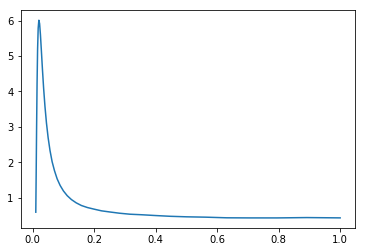

In [17]:
lr_plot(lrfind_callbacks[0], lrfind_callbacks[1])

In [ ]:
model, callbacks = fit_model(model = model, n_epoch = n_epoch, dev_dataloader = dev_dataloader, optimizer = optimizer, criterion = criterion, callbacks = callbacks, val_dataloader = val_dataloader)